# Fraud Detection

### Main objective

Vehicle insurance fraud involves conspiring to make false or exaggerated claims involving property damage or personal injuries following an accident.

Main objective of this study is to build a model that can detect this type of fraud.
As first move I'll build a random forest as benchmarch for performance then I'll use the Keras package to build and train a neural network. At last I'll do some parameter tuning to find the best result for fraud detection.

I took the data on kaggle searching for "vehicle claim fraud detection".


In [1]:
#Setup
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler

In [2]:
## Import Keras objects for Deep Learning
from tensorflow.keras.models  import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

2023-03-06 18:09:25.293901: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-06 18:09:25.293995: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Data import and exploration

In [3]:
## Load in the data set 
fraud_df = pd.read_csv('data/fraud_oracle.csv')
print(fraud_df.shape)
fraud_df.sample(5)

(15420, 33)


,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
9872,Feb,1,Sunday,Mazda,Urban,Monday,Feb,1,Male,Married,...,7 years,31 to 35,No,No,External,1 to 2,no change,1 vehicle,1995,Collision
2973,Apr,3,Monday,Honda,Urban,Wednesday,May,2,Male,Married,...,6 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision
8317,Aug,1,Monday,Pontiac,Urban,Friday,Aug,2,Male,Single,...,7 years,31 to 35,No,No,External,more than 5,no change,1 vehicle,1995,Liability
8918,Mar,2,Saturday,Pontiac,Urban,Friday,Mar,3,Male,Married,...,6 years,31 to 35,No,No,External,none,1 year,1 vehicle,1995,Collision
6462,Apr,3,Saturday,Chevrolet,Urban,Tuesday,Apr,4,Male,Single,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1995,All Perils


In [4]:
print(f'Has dataset some null value?   - {fraud_df.isnull().values.any()}')
fraud_df.drop_duplicates()
print(f'dataset has {len(fraud_df)} rows')

print('\nHere are the first 3 rows of dataset (transposed for easier reading)')
print(fraud_df.head(3).T)


Has dataset some null value?   - False
dataset has 15420 rows

Here are the first 3 rows of dataset (transposed for easier reading)
                                      0                  1                  2
Month                               Dec                Jan                Oct
WeekOfMonth                           5                  3                  5
DayOfWeek                     Wednesday          Wednesday             Friday
Make                              Honda              Honda              Honda
AccidentArea                      Urban              Urban              Urban
DayOfWeekClaimed                Tuesday             Monday           Thursday
MonthClaimed                        Jan                Jan                Nov
WeekOfMonthClaimed                    1                  4                  2
Sex                              Female               Male               Male
MaritalStatus                    Single             Single            Married
Age       


There are 15420 rows in dataset and columns contains different types of values (numeric and string).

The variable named 'FraudFound_P' is the one I want to predict and it is "1" for fraud detected or "0" otherwise.

Data is pretty well formatted and it’s not need any cleaning operation but some operation needs to be done to know witch of all these variables has greater impact on target variable.


In [5]:
#transforming strings to integer data
def transform(column):
    label=LabelEncoder().fit_transform(fraud_df[column])
    fraud_df.drop(column,axis=1,inplace=True)
    fraud_df[column]=label
def multi_transform(list):
    mt_list=[]
    for x in list:
        if x not in mt_list:
            transform(x)
multi_transform(fraud_df.columns.to_list())

#calculating the correlation between each variable and fraud
def multi_corr(column):
    df = pd.DataFrame(columns=['variable', 'corr_to_FraudFound_P'])
    corr_list=[]
    for x in column:
        if x not in corr_list:
            c=fraud_df['FraudFound_P'].corr(fraud_df[x],method='pearson',min_periods=1)
            df = df.append({'variable': x, 'corr_to_FraudFound_P': round(c,2)},ignore_index=True)
    df = df.sort_values(by = ['corr_to_FraudFound_P']).set_index('variable')
    print(df)
    df.corr_to_FraudFound_P = abs(df.corr_to_FraudFound_P)
    print(df.sort_values(by = ['corr_to_FraudFound_P'], ascending=False).head(15))

multi_corr(fraud_df.columns.to_list())



                     corr_to_FraudFound_P
variable                                 
BasePolicy                          -0.16
Fault                               -0.13
VehicleCategory                      -0.1
PolicyType                          -0.06
AddressChange_Claim                 -0.04
AccidentArea                        -0.03
AgeOfPolicyHolder                   -0.03
Age                                 -0.03
AgentType                           -0.02
PoliceReportFiled                   -0.02
AgeOfVehicle                        -0.02
Days_Policy_Claim                   -0.02
Year                                -0.02
PolicyNumber                        -0.02
DayOfWeek                           -0.02
Make                                -0.02
MonthClaimed                        -0.01
WeekOfMonth                         -0.01
WitnessPresent                      -0.01
WeekOfMonthClaimed                  -0.01
Month                               -0.01
RepNumber                         

Observing correlation between target and other variables is clear that some of them have a greater impact on fraud detection then the others.
To ease a little bit the study I’ll take just the most correlated variables (absolute value). Those are: BasePolicy, VehicleCategory, VehiclePrice, PolicyType, AddressChange_Claim, AccidentArea, AgeOfPolicyHolder, Age, Deductible, Sex.

There is no need for further feature engineering.


### Data preparation - di seguito un tentativo cercare, come si comporta l'amico su kaggle

In [6]:
df = fraud_df[['BasePolicy', 'VehicleCategory', 'VehiclePrice', 'PolicyType',
               'AddressChange_Claim', 'AccidentArea', 'AgeOfPolicyHolder',
               'Age','Deductible','Sex', 'FraudFound_P']]

perc_fraud_detected = len(df[df.FraudFound_P==1])/len(df[df.FraudFound_P==0])
print(f'Percentage of rows corresponding to detected fraud: {perc_fraud_detected}')

Percentage of rows corresponding to detected fraud: 0.06366834517486376


In [7]:
# creating a balanced dataset by under-sempling ...
#df_1 = df[df.FraudFound_P == 1]
#df_0 = df[df.FraudFound_P == 0].sample(n = len(df_1), random_state = 123)
#df = df_1.append(df_0)
#X = df.iloc[:, :-1].values
#y = df['FraudFound_P'].values

# creating a balanced dataset by over-sempling ...
X_imbalanced = df.iloc[:, :-1]
y_imbalanced = df['FraudFound_P']

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X_imbalanced, y_imbalanced)

X = X_ros.values
y = y_ros.values

In [8]:
# Split the data to Train, and Test (75%, 25%)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)
#X_train, X_test, y_train, y_test = StratifiedShuffleSplit(X, y, test_size=0.25, random_state=11111)

In [9]:
np.mean(y), np.mean(1-y), len(y)

(0.5, 0.5, 28994)

Without any balancing operation for dataset, I see that about 6% of rows in this dataset correspond to detected fraud, while 94% do not.  This means I can get an accuracy of 94% without any model - just declaring that nobody does fraud. 

I created a balanced dataset by taking all the rows corresponding to detected fraud and the same amount of the other rows... but this kind of undersampling didn't works because it lead to wicker accuracy for predictions with neural network. So, I balanced the dataset by over sempling rows corresponding to fraud detected making dataset become 28994 rows.

Now I'll build a Random Forest Classifier with 200 trees as a benchmarck for neural network models.
I'll calculate the ROC-AUC score to evaluate performance of the model, and also look at the accuracy as well to see if we improved upon the 50% accuracy on this balanced set.


In [10]:
### BEGIN SOLUTION
## Train the RF Model
rf_model = RandomForestClassifier(n_estimators=200)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

In [11]:
# Make predictions on the test set - both "hard" predictions, and the scores (percent of trees voting yes)
y_pred_class_rf = rf_model.predict(X_test)
y_pred_prob_rf = rf_model.predict_proba(X_test)


print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_rf)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_rf[:,1])))

accuracy is 0.793
roc-auc is 0.881


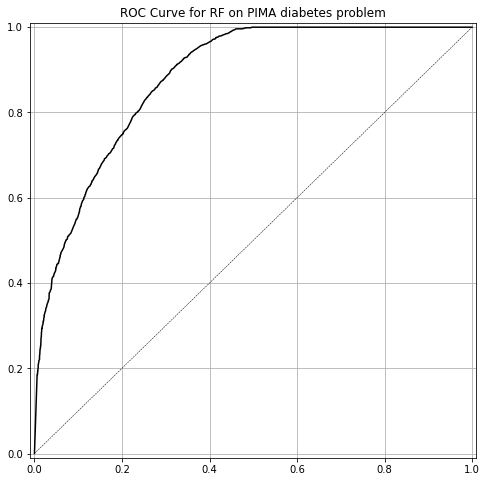

In [12]:
def plot_roc(y_test, y_pred, model_name):
    fpr, tpr, thr = roc_curve(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(fpr, tpr, 'k-')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=.5)  # roc curve for random model
    ax.grid(True)
    ax.set(title='ROC Curve for {} on PIMA diabetes problem'.format(model_name),
           xlim=[-0.01, 1.01], ylim=[-0.01, 1.01])
plot_roc(y_test, y_pred_prob_rf[:, 1], 'RF')
### END SOLUTION

Accuracy is not extremly high but way better then 50%, so the random forest is the new benchmark.


## Neural Networks

Now I'll use the Sequential model to build three neural networks with differeent hidden leyers:
 - single layer with 10 nodes
 - single layer with 15 nodes
 - double layer (with 10 nodes for each layer).

For any of the models I'll set the input shape to 10 and a final layer with one node and a sigmoid activation will complete the neural networks.

But first I need to normalize the data.

In [13]:
normalizer = StandardScaler()
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

In [14]:
# Define the Models 

# first model: 10-dimensional input + 1 hidden layer (10 nodes, sigmoid activation)
model_1 = Sequential()
model_1.add(Dense(10,input_shape = (10,),activation = 'sigmoid'))
model_1.add(Dense(1,activation='sigmoid'))

# second model: 10-dimensional input + 1 hidden layer (15 nodes, relu activation)
model_2 = Sequential()
model_2.add(Dense(15,input_shape = (10,),activation = 'relu'))
model_2.add(Dense(1,activation='sigmoid'))

# third model: 10-dimensional input + first hidden layer (10 nodes, sigmoid activation)
# + second hidden layer (10 nodes, relu activation)
model_3 = Sequential()
model_3.add(Dense(10,input_shape = (10,),activation = 'sigmoid'))
model_3.add(Dense(10,input_shape = (10,),activation = 'relu'))
model_3.add(Dense(1,activation='sigmoid'))

2023-03-06 18:09:43.511017: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-06 18:09:43.511141: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-06 18:09:43.511204: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (eros-HP-Notebook): /proc/driver/nvidia/version does not exist


### Model 1 - one hidden layer with sigmoid activation function

In [15]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                110       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Fit(Train) the Model
# Compile the model with Optimizer, Loss Function and Metrics

model_1.compile(SGD(lr = .003), "binary_crossentropy", metrics=["accuracy"])
run_hist_1 = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=50)

Epoch 1/50
680/680 [==============================] - 6s 7ms/step - loss: 0.7175 - accuracy: 0.4665 - val_loss: 0.7125 - val_accuracy: 0.4947
Epoch 2/50
680/680 [==============================] - 4s 6ms/step - loss: 0.7051 - accuracy: 0.5121 - val_loss: 0.7011 - val_accuracy: 0.5272
Epoch 3/50
680/680 [==============================] - 4s 5ms/step - loss: 0.6952 - accuracy: 0.5343 - val_loss: 0.6919 - val_accuracy: 0.5441
Epoch 4/50
680/680 [==============================] - 4s 5ms/step - loss: 0.6872 - accuracy: 0.5497 - val_loss: 0.6843 - val_accuracy: 0.5602
Epoch 5/50
680/680 [==============================] - 4s 6ms/step - loss: 0.6804 - accuracy: 0.5631 - val_loss: 0.6778 - val_accuracy: 0.5754
Epoch 6/50
680/680 [==============================] - 4s 6ms/step - loss: 0.6745 - accuracy: 0.5779 - val_loss: 0.6721 - val_accuracy: 0.5884
Epoch 7/50
680/680 [==============================] - 4s 6ms/step - loss: 0.6694 - accuracy: 0.5863 - val_loss: 0.6670 - val_accuracy: 0.5964
Epoch 

In [17]:
## Like I did for the Random Forest, I generate two kinds of predictions
#  One is a hard decision, the other is a probabilitistic score.

y_pred_prob_nn_1 = model_1.predict(X_test_norm)
y_pred_class_nn_1 = [round(i[0]) for i in y_pred_prob_nn_1]

result_pred_and_score = pd.DataFrame(data={
    'probabilistic score': [i[0] for i in y_pred_prob_nn_1],
    'decision': y_pred_class_nn_1})
print(result_pred_and_score.head(10))

227/227 [==============================] - 1s 3ms/step
   probabilistic score  decision
0             0.480771         0
1             0.739645         1
2             0.480771         0
3             0.708383         1
4             0.425041         0
5             0.695508         1
6             0.654436         1
7             0.629737         1
8             0.648685         1
9             0.618781         1


accuracy is 0.647
roc-auc is 0.716


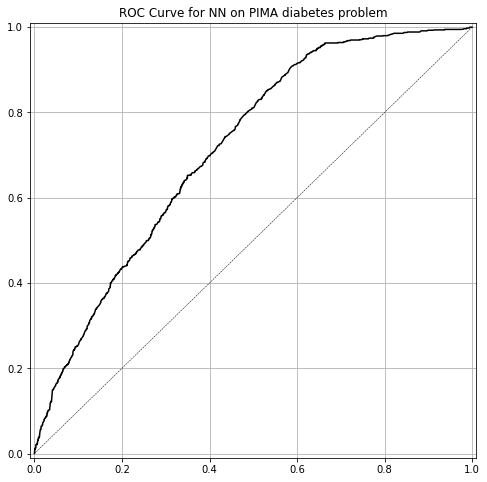

In [18]:
# Print model performance and plot the roc curve
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_1)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_1)))

plot_roc(y_test, y_pred_prob_nn_1, 'NN')

This model has a lower accuracy then randome forest.

Let's plot the training loss and the validation loss over the different epochs and see how it looks.

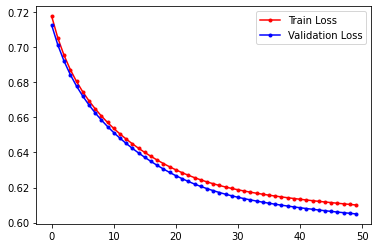

In [19]:
fig, ax = plt.subplots()
ax.plot(run_hist_1.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss")
#ax.plot(run_hist_1.history["accuracy"],'y', marker='.', label="Accuracy")
ax.legend()

Looks like the losses are still going down on both the training set and the validation set but with a slight flattening of the curve. Train the model with more epochs will not lead to significant increase in prediction accuracy. I'll move on to the next model.

### Model 2 - one hidden layer with relu activation function

In [20]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 15)                165       
                                                                 
 dense_3 (Dense)             (None, 1)                 16        
                                                                 
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Fit(Train) the Model
# Compile the model with Optimizer, Loss Function and Metrics

model_2.compile(SGD(lr = .01), "binary_crossentropy", metrics=["accuracy"])
run_hist_2 = model_2.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=50)

Epoch 1/50
680/680 [==============================] - 5s 6ms/step - loss: 0.6539 - accuracy: 0.6014 - val_loss: 0.6139 - val_accuracy: 0.6326
Epoch 2/50
680/680 [==============================] - 4s 5ms/step - loss: 0.6110 - accuracy: 0.6352 - val_loss: 0.6016 - val_accuracy: 0.6486
Epoch 3/50
680/680 [==============================] - 4s 6ms/step - loss: 0.6045 - accuracy: 0.6416 - val_loss: 0.5977 - val_accuracy: 0.6544
Epoch 4/50
680/680 [==============================] - 4s 5ms/step - loss: 0.6021 - accuracy: 0.6470 - val_loss: 0.5964 - val_accuracy: 0.6467
Epoch 5/50
680/680 [==============================] - 4s 5ms/step - loss: 0.6007 - accuracy: 0.6489 - val_loss: 0.5947 - val_accuracy: 0.6521
Epoch 6/50
680/680 [==============================] - 4s 5ms/step - loss: 0.5996 - accuracy: 0.6508 - val_loss: 0.5940 - val_accuracy: 0.6553
Epoch 7/50
680/680 [==============================] - 4s 5ms/step - loss: 0.5989 - accuracy: 0.6523 - val_loss: 0.5930 - val_accuracy: 0.6558
Epoch 

In [22]:
## Like I did for the Random Forest, I generate two kinds of predictions
#  One is a hard decision, the other is a probabilitistic score.

y_pred_prob_nn_2 = model_2.predict(X_test_norm)
y_pred_class_nn_2 = [round(i[0]) for i in y_pred_prob_nn_2]

result_pred_and_score = pd.DataFrame(data={
    'probabilistic score': [i[0] for i in y_pred_prob_nn_2],
    'decision': y_pred_class_nn_2})
print(result_pred_and_score.head(10))

227/227 [==============================] - 1s 3ms/step
   probabilistic score  decision
0             0.495783         0
1             0.684015         1
2             0.495783         0
3             0.729813         1
4             0.573764         1
5             0.623636         1
6             0.597228         1
7             0.579130         1
8             0.591977         1
9             0.592757         1


accuracy is 0.664
roc-auc is 0.743


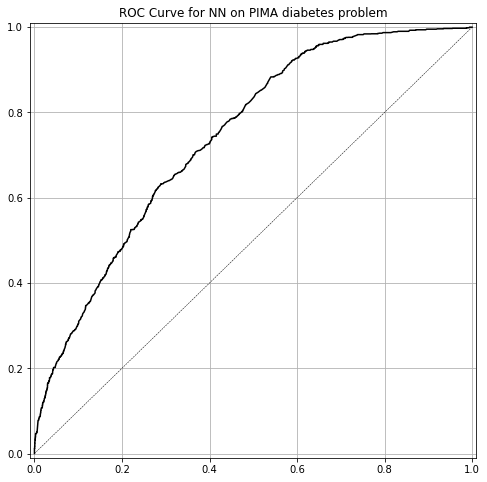

In [23]:
# Print model performance and plot the roc curve
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_2)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_2)))

plot_roc(y_test, y_pred_prob_nn_2, 'NN')

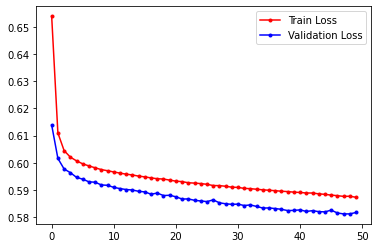

In [24]:
# plot the training loss and the validation loss over the different epochs.
fig, ax = plt.subplots()
ax.plot(run_hist_2.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_2.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

### Model 3 - two hidden layers (first with relu and second with sigmoid activation functions)

In [25]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 10)                110       
                                                                 
 dense_5 (Dense)             (None, 10)                110       
                                                                 
 dense_6 (Dense)             (None, 1)                 11        
                                                                 
Total params: 231
Trainable params: 231
Non-trainable params: 0
_________________________________________________________________


In [26]:
# Fit(Train) the Model
# Compile the model with Optimizer, Loss Function and Metrics

model_3.compile(SGD(lr = .003), "binary_crossentropy", metrics=["accuracy"])
run_hist_3 = model_3.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=50)

Epoch 1/50
680/680 [==============================] - 5s 6ms/step - loss: 0.7008 - accuracy: 0.5388 - val_loss: 0.6970 - val_accuracy: 0.5541
Epoch 2/50
680/680 [==============================] - 4s 6ms/step - loss: 0.6914 - accuracy: 0.5649 - val_loss: 0.6882 - val_accuracy: 0.5641
Epoch 3/50
680/680 [==============================] - 4s 6ms/step - loss: 0.6840 - accuracy: 0.5713 - val_loss: 0.6814 - val_accuracy: 0.5733
Epoch 4/50
680/680 [==============================] - 4s 6ms/step - loss: 0.6785 - accuracy: 0.5873 - val_loss: 0.6763 - val_accuracy: 0.5929
Epoch 5/50
680/680 [==============================] - 4s 6ms/step - loss: 0.6736 - accuracy: 0.5990 - val_loss: 0.6710 - val_accuracy: 0.6035
Epoch 6/50
680/680 [==============================] - 4s 6ms/step - loss: 0.6686 - accuracy: 0.6126 - val_loss: 0.6656 - val_accuracy: 0.6169
Epoch 7/50
680/680 [==============================] - 4s 6ms/step - loss: 0.6636 - accuracy: 0.6189 - val_loss: 0.6604 - val_accuracy: 0.6182
Epoch 

In [27]:
## Like I did for the Random Forest, I generate two kinds of predictions
#  One is a hard decision, the other is a probabilitistic score.

y_pred_prob_nn_3 = model_3.predict(X_test_norm)
y_pred_class_nn_3 = [round(i[0]) for i in y_pred_prob_nn_3]

result_pred_and_score = pd.DataFrame(data={
    'probabilistic score': [i[0] for i in y_pred_prob_nn_3],
    'decision': y_pred_class_nn_3})
print(result_pred_and_score.head(10))

227/227 [==============================] - 1s 3ms/step
   probabilistic score  decision
0             0.540545         1
1             0.721030         1
2             0.540545         1
3             0.718525         1
4             0.483585         0
5             0.664228         1
6             0.641054         1
7             0.596153         1
8             0.630478         1
9             0.582622         1


accuracy is 0.660
roc-auc is 0.722


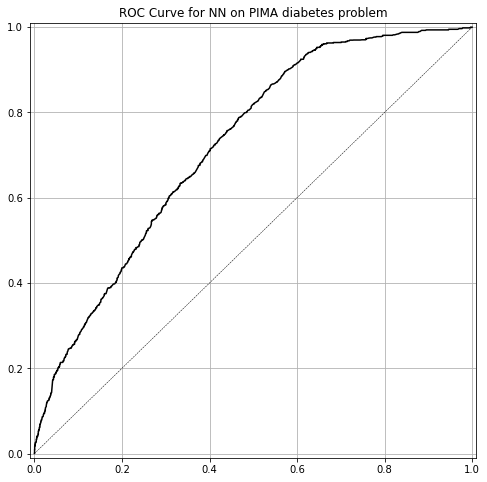

In [28]:
# Print model performance and plot the roc curve
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_3)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_3)))

plot_roc(y_test, y_pred_prob_nn_3, 'NN')

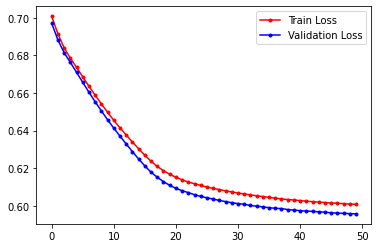

In [29]:
# plot the training loss and the validation loss over the different epochs.
fig, ax = plt.subplots()
ax.plot(run_hist_3.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_3.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

### Results and conclusions

Below a comparison of the result obtained by the three models.

In [30]:
results_accuracy =  pd.DataFrame(data={
    'model': ['random forest',
              'NN model 1 (one sigmoid layer)',
              'NN model 2 (one relu layer)',
              'MM model 3 (two layers, sigmoid+relu)'],
    'accuracy': [accuracy_score(y_test,y_pred_class_rf),
                 accuracy_score(y_test,y_pred_class_nn_1),
                 accuracy_score(y_test,y_pred_class_nn_2),
                 accuracy_score(y_test,y_pred_class_nn_3)],
    'roc-auc': [roc_auc_score(y_test,y_pred_prob_rf[:,1]),
                roc_auc_score(y_test,y_pred_prob_nn_1),
                roc_auc_score(y_test,y_pred_prob_nn_2),
                roc_auc_score(y_test,y_pred_prob_nn_3)]})
print(results_accuracy)

print('\nPredictions comparison for the three neural network models on the first 10 test observation.\n')
predicted_results = pd.DataFrame(data={
    'model_1': y_pred_class_nn_1,
    'model_2': y_pred_class_nn_2,
    'model_3': y_pred_class_nn_3})
print(predicted_results.head(10))


                                   model  accuracy   roc-auc
0                          random forest  0.793213  0.880937
1         NN model 1 (one sigmoid layer)  0.646848  0.715881
2            NN model 2 (one relu layer)  0.664367  0.743157
3  MM model 3 (two layers, sigmoid+relu)  0.659677  0.721868

Predictions comparison for the three neural network models on the first 10 test observation.

   model_1  model_2  model_3
0        0        0        1
1        1        1        1
2        0        0        1
3        1        1        1
4        0        1        0
5        1        1        1
6        1        1        1
7        1        1        1
8        1        1        1
9        1        1        1


All the three neural network model have a wicker prediction accuracy the random forest model. I think the cause could be the train set not large enough to allow the use of deep learning. It's also a inbalanced problem and the over sample of data corresponding to fraud detected could has lead to some overfitting, better handled by the random forest then the neural network. 
Anyway, the three Neural network models has similar values for accuracy and roc-auc score and between them the second model seems slightely better then the others in both score parameters.



A lot of experiment could be done to reach a better result in accuracy and roc-auc score by tuning learning rate and number of epochs. For example the second model has 0.01 as learning rate, way higher then the others two model. This lead faster to an increase in accuracy but made the neural network tuning less precise. A slower learning rate and a higher number of epochs allow for sure to a better network shaping and an increase in accuracy but it requires a lot of time and some computational resources better then my cheap laptop.

Cheers.